# tf.data: Build TensorFlow input pipelines

In [2]:
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

import tensorflow as tf

print("The version of Tensorflow: {}".format(tf.__version__))

The version of Tensorflow: 2.4.1


## 1. Basic mechanics

In [3]:
# The Dataset object is a Python iterable. This makes it possible to consume its elements using a for loop:

dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [4]:
for elem in dataset:
  print(elem.numpy())

8
3
0
8
2
1


In [5]:
# Or by explicitly creating a Python iterator using iter and consuming its elements using next:

it = iter(dataset)

print(next(it).numpy())

8


In [6]:
# Alternatively, dataset elements can be consumed using the reduce transformation, 
# which reduces all elements to produce a single result. 
# The following example illustrates how to use the reduce transformation to compute the sum of a dataset of integers.

print(dataset.reduce(0, lambda state, value: state + value).numpy())

22


### Dataset structure 

In [7]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

dataset1.element_spec

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [8]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2.element_spec

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [9]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

In [10]:
# Dataset containing a sparse tensor.
dataset4 = tf.data.Dataset.from_tensors(tf.SparseTensor(indices=[[0, 0], [1, 2]], values=[1, 2], dense_shape=[3, 4]))

dataset4.element_spec

SparseTensorSpec(TensorShape([3, 4]), tf.int32)

In [11]:
# Use value_type to see the type of value represented by the element spec
dataset4.element_spec.value_type

tensorflow.python.framework.sparse_tensor.SparseTensor

In [12]:
dataset1 = tf.data.Dataset.from_tensor_slices(
    tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32))

dataset1

<TensorSliceDataset shapes: (10,), types: tf.int32>

In [13]:
for z in dataset1:
  print(z.numpy())

[7 6 9 4 6 8 4 2 9 6]
[5 8 8 5 5 9 9 6 4 3]
[2 5 4 9 9 6 3 9 8 7]
[5 9 6 4 4 5 3 3 4 8]


In [14]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2

<TensorSliceDataset shapes: ((), (100,)), types: (tf.float32, tf.int32)>

In [15]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3

<ZipDataset shapes: ((10,), ((), (100,))), types: (tf.int32, (tf.float32, tf.int32))>

In [16]:
for a, (b,c) in dataset3:
  print('shapes: {a.shape}, {b.shape}, {c.shape}'.format(a=a, b=b, c=c))

shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)


## 2. Reading input data

### i. Consuming NumPy arrays

In [17]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

In [18]:
images, labels = train
images = images/255

dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset

<TensorSliceDataset shapes: ((28, 28), ()), types: (tf.float64, tf.uint8)>

### ii. Consuming Python generators

In [19]:
def count(stop):
  i = 0
  while i<stop:
    yield i
    i += 1

In [20]:
for n in count(5):
  print(n)

0
1
2
3
4


In [21]:
ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=tf.int32, output_shapes = (), )

In [22]:
for count_batch in ds_counter.repeat().batch(10).take(10):
  print(count_batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]
[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]


In [23]:
def gen_series():
  i = 0
  while True:
    size = np.random.randint(0, 10)
    yield i, np.random.normal(size=(size,))
    i += 1

In [24]:
for i, series in gen_series():
  print(i, ":", str(series))
  if i > 5:
    break

0 : [ 0.5832 -0.2344 -0.7393 -0.0431 -1.0229  0.0537 -0.3397]
1 : []
2 : [-1.4253 -0.067 ]
3 : [-0.7985  0.1426  0.0089]
4 : [ 0.2193 -1.2213 -1.1228]
5 : [-1.7471  0.4091  2.1952 -0.5522  0.7655]
6 : [ 1.6469  0.3629 -0.2021 -0.3918  0.477   1.2794]


In [25]:
ds_series = tf.data.Dataset.from_generator(
    gen_series, 
    output_types=(tf.int32, tf.float32), 
    output_shapes=((), (None,)))

ds_series

<FlatMapDataset shapes: ((), (None,)), types: (tf.int32, tf.float32)>

In [26]:
ds_series_batch = ds_series.shuffle(20).padded_batch(10)

ids, sequence_batch = next(iter(ds_series_batch))
print(ids.numpy())
print()
print(sequence_batch.numpy())

[12  3 19 21  7 20 10 15 27 26]

[[-0.7235  1.9736  0.6075  1.0004 -0.6223 -0.6797  0.4045 -0.2325 -1.4968]
 [ 0.3516  1.4501 -1.5597  0.4684  0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 1.4773  0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 1.1886 -0.8015  0.3243 -0.2579  2.0374 -0.3372  1.1085  1.791  -0.4817]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 1.8491  0.8134 -0.2104  0.5958  0.      0.      0.      0.      0.    ]
 [-0.6929  0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.5141  0.3879  0.      0.      0.      0.      0.      0.      0.    ]]


In [27]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [28]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

In [29]:
images, labels = next(img_gen.flow_from_directory(flowers))

Found 3670 images belonging to 5 classes.


In [30]:
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 256, 256, 3)
float32 (32, 5)


In [31]:
ds = tf.data.Dataset.from_generator(
    lambda: img_gen.flow_from_directory(flowers), 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([32,256,256,3], [32,5])
)

ds.element_spec

(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

In [32]:
for images, label in ds.take(1):
  print('images.shape: ', images.shape)
  print('labels.shape: ', labels.shape)

Found 3670 images belonging to 5 classes.
images.shape:  (32, 256, 256, 3)
labels.shape:  (32, 5)


### iii. Consuming TFRecord data

In [33]:
# Here is an example using the test file from the French Street Name Signs (FSNS).

# Creates a dataset that reads all of the examples from two files.
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")

7905280/7904079 [==============================] - 3s 0us/step


In [34]:
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [35]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

parsed.features.feature['image/text']

bytes_list {
  value: "Rue Perreyon"
}

### iv. Consuming text data 

In [36]:
directory_url = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
file_names = ['cowper.txt', 'derby.txt', 'butler.txt']

file_paths = [
    tf.keras.utils.get_file(file_name, directory_url + file_name)
    for file_name in file_names
]

811008/807992 [==============================] - 0s 0us/step


In [37]:
dataset = tf.data.TextLineDataset(file_paths)

In [38]:
for line in dataset.take(5):
  print(line.numpy())

b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b'His wrath pernicious, who ten thousand woes'
b"Caused to Achaia's host, sent many a soul"
b'Illustrious into Ades premature,'
b'And Heroes gave (so stood the will of Jove)'


In [39]:
files_ds = tf.data.Dataset.from_tensor_slices(file_paths)
lines_ds = files_ds.interleave(tf.data.TextLineDataset, cycle_length=3)

for i, line in enumerate(lines_ds.take(9)):
  if i % 3 == 0:
    print()
  print(line.numpy())


b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b"\xef\xbb\xbfOf Peleus' son, Achilles, sing, O Muse,"
b'\xef\xbb\xbfSing, O goddess, the anger of Achilles son of Peleus, that brought'

b'His wrath pernicious, who ten thousand woes'
b'The vengeance, deep and deadly; whence to Greece'
b'countless ills upon the Achaeans. Many a brave soul did it send'

b"Caused to Achaia's host, sent many a soul"
b'Unnumbered ills arose; which many a soul'
b'hurrying down to Hades, and many a hero did it yield a prey to dogs and'


In [40]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [41]:
for line in titanic_lines.take(10):
  print(line.numpy())

b'survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone'
b'0,male,22.0,1,0,7.25,Third,unknown,Southampton,n'
b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y'
b'0,male,2.0,3,1,21.075,Third,unknown,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'


In [42]:
def survived(line):
  return tf.not_equal(tf.strings.substr(line, 0, 1), "0")

survivors = titanic_lines.skip(1).filter(survived)

In [43]:
for line in survivors.take(10):
  print(line.numpy())

b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'
b'1,male,28.0,0,0,13.0,Second,unknown,Southampton,y'
b'1,female,28.0,0,0,7.225,Third,unknown,Cherbourg,y'
b'1,male,28.0,0,0,35.5,First,A,Southampton,y'
b'1,female,38.0,1,5,31.3875,Third,unknown,Southampton,n'


### v. Consuming CSV data

In [44]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

In [45]:
df = pd.read_csv(titanic_file)
df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [46]:
titanic_slices = tf.data.Dataset.from_tensor_slices(dict(df))

for feature_batch in titanic_slices.take(1):
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

  'survived'          : 0
  'sex'               : b'male'
  'age'               : 22.0
  'n_siblings_spouses': 1
  'parch'             : 0
  'fare'              : 7.25
  'class'             : b'Third'
  'deck'              : b'unknown'
  'embark_town'       : b'Southampton'
  'alone'             : b'n'


In [47]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived")

In [48]:
for feature_batch, label_batch in titanic_batches.take(1):
  print("'survived': {}".format(label_batch))
  print("features:")
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

'survived': [0 1 1 0]
features:
  'sex'               : [b'female' b'male' b'female' b'male']
  'age'               : [28. 25. 30. 28.]
  'n_siblings_spouses': [8 1 0 0]
  'parch'             : [2 0 0 0]
  'fare'              : [69.55   7.775 31.     7.225]
  'class'             : [b'Third' b'Third' b'First' b'Third']
  'deck'              : [b'unknown' b'unknown' b'unknown' b'unknown']
  'embark_town'       : [b'Southampton' b'Southampton' b'Cherbourg' b'Cherbourg']
  'alone'             : [b'n' b'n' b'y' b'y']


In [49]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived", select_columns=['class', 'fare', 'survived'])

In [50]:
for feature_batch, label_batch in titanic_batches.take(1):
  print("'survived': {}".format(label_batch))
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

'survived': [1 1 0 0]
  'fare'              : [51.4792 13.7917 24.     52.    ]
  'class'             : [b'First' b'Second' b'Second' b'First']


In [51]:
titanic_types  = [tf.int32, tf.string, tf.float32, tf.int32, tf.int32, tf.float32, tf.string, tf.string, tf.string, tf.string] 
dataset = tf.data.experimental.CsvDataset(titanic_file, titanic_types , header=True)

for line in dataset.take(10):
  print([item.numpy() for item in line])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 38.0, 1, 0, 71.2833, b'First', b'C', b'Cherbourg', b'n']
[1, b'female', 26.0, 0, 0, 7.925, b'Third', b'unknown', b'Southampton', b'y']
[1, b'female', 35.0, 1, 0, 53.1, b'First', b'C', b'Southampton', b'n']
[0, b'male', 28.0, 0, 0, 8.4583, b'Third', b'unknown', b'Queenstown', b'y']
[0, b'male', 2.0, 3, 1, 21.075, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 27.0, 0, 2, 11.1333, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 14.0, 1, 0, 30.0708, b'Second', b'unknown', b'Cherbourg', b'n']
[1, b'female', 4.0, 1, 1, 16.7, b'Third', b'G', b'Southampton', b'n']
[0, b'male', 20.0, 0, 0, 8.05, b'Third', b'unknown', b'Southampton', b'y']


In [52]:
%%writefile missing.csv
1,2,3,4
,2,3,4
1,,3,4
1,2,,4
1,2,3,
,,,

Writing missing.csv


In [53]:
# Creates a dataset that reads all of the records from two CSV files, each with
# four float columns which may have missing values.

record_defaults = [999,999,999,999]
dataset = tf.data.experimental.CsvDataset("missing.csv", record_defaults)
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<MapDataset shapes: (4,), types: tf.int32>

In [54]:
for line in dataset:
  print(line.numpy())

[1 2 3 4]
[999   2   3   4]
[  1 999   3   4]
[  1   2 999   4]
[  1   2   3 999]
[999 999 999 999]


In [55]:
# Creates a dataset that reads all of the records from two CSV files with
# headers, extracting float data from columns 2 and 4.
record_defaults = [999, 999] # Only provide defaults for the selected columns
dataset = tf.data.experimental.CsvDataset("missing.csv", record_defaults, select_cols=[1, 3])
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<MapDataset shapes: (2,), types: tf.int32>

In [56]:
for line in dataset:
  print(line.numpy())

[2 4]
[2 4]
[999   4]
[2 4]
[  2 999]
[999 999]


### vi. Consuming sets of files

In [57]:
# There are many datasets distributed as a set of files, where each file is an example.

flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)

In [58]:
for item in flowers_root.glob("*"):
  print(item.name)

daisy
dandelion
LICENSE.txt
roses
sunflowers
tulips


In [59]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\admin\\.keras\\datasets\\flower_photos\\tulips\\13979098015_e8c98fd34e_n.jpg'
b'C:\\Users\\admin\\.keras\\datasets\\flower_photos\\daisy\\9054268881_19792c5203_n.jpg'
b'C:\\Users\\admin\\.keras\\datasets\\flower_photos\\tulips\\5674134129_2db5136cba.jpg'
b'C:\\Users\\admin\\.keras\\datasets\\flower_photos\\daisy\\9350942387_5b1d043c26_n.jpg'
b'C:\\Users\\admin\\.keras\\datasets\\flower_photos\\sunflowers\\193878348_43571127b9_n.jpg'


In [61]:
def process_path(file_path):
  label = tf.strings.split(file_path, os.sep)[-2]
  return tf.io.read_file(file_path), label

labeled_ds = list_ds.map(process_path)

In [62]:
for image_raw, label_text in labeled_ds.take(1):
  print(repr(image_raw.numpy()[:100]))
  print()
  print(label_text.numpy())

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05'

b'daisy'


## 3. Batching dataset elements

### i. Simple batching

In [63]:
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
  print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3], dtype=int64), array([ 0, -1, -2, -3], dtype=int64)]
[array([4, 5, 6, 7], dtype=int64), array([-4, -5, -6, -7], dtype=int64)]
[array([ 8,  9, 10, 11], dtype=int64), array([ -8,  -9, -10, -11], dtype=int64)]
[array([12, 13, 14, 15], dtype=int64), array([-12, -13, -14, -15], dtype=int64)]


In [64]:
batched_dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.int64)>

In [65]:
batched_dataset = dataset.batch(7, drop_remainder=True)
batched_dataset

<BatchDataset shapes: ((7,), (7,)), types: (tf.int64, tf.int64)>

### ii. Batching tensors with padding

In [67]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes=(None,))

for batch in dataset.take(2):
  print(batch.numpy())
  print()

[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



## 4. Training workflows

### i. Processing multiple epochs

In [69]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [70]:
def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

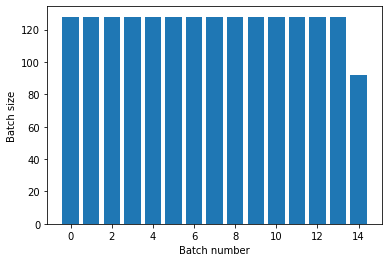

In [71]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

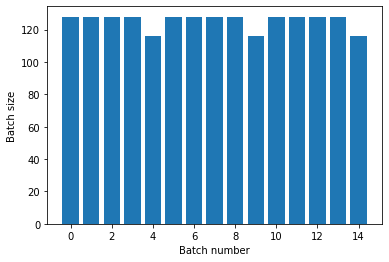

In [72]:
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)

In [73]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
  for batch in dataset:
    print(batch.shape)
  print("End of epoch: ", epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


### ii. Randomly shuffling input data

In [75]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.string)>

In [76]:
n,line_batch = next(iter(dataset))
print(n.numpy())

[ 4 46 18 65 41 54 34 45 10 22 99 50  9 53 11 68 33 72 56 76]


In [77]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[624 577 333 565 352 546 598 471 589 601]
[585 221 393 411 413 610 606 495 500 537]
[501 579 553 519 569 574 621 618]
[85 42 96  7 20  9 81 27 60 86]
[ 31  17  93   4  50  18  78 114  24  83]


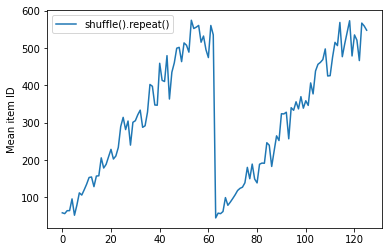

In [78]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

In [79]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())

Here are the item ID's near the epoch boundary:

[578   5 607 521 591 516 570   7 583  14]
[598  31 402 507 223 572 511 426 528   6]
[282 627  19  30 609 575 577 542  11  46]
[ 13 569 409  54  48 590 351   2 430  15]
[557  18  28 596 360 580 348  40 579 503]
[ 21  56  25  47  61 626  52  42  22  71]
[ 81  75   0 558 463  77  38  84 597  45]
[423 488  79  59  76  65 367  98  78  62]
[319  86 601 499  68 592   8 100 483 509]
[102  27 481  94 421  24   9 568  51 470]
[ 92 619 616 497  82 113 106 475 302  69]
[ 70 126 612  20 130  74 547 605  93  17]
[ 67 611  26 104 622  91 135 140  35  57]
[119 124  49  73 128 143  34 564  10  23]
[ 37 122 587 158 154  66 118 138 114 160]


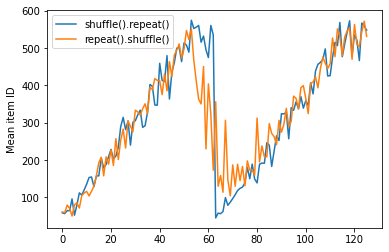

In [80]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

## 5. Preprocessing data

### i. Decoding image data and resizing it

In [81]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

In [82]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

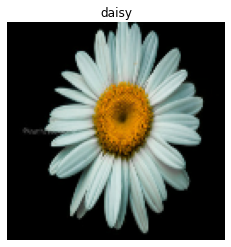

In [83]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)

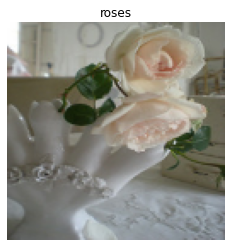

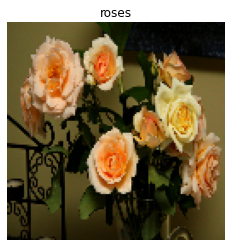

In [84]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
  show(image, label)

### ii. Applying arbitrary Python logic

In [85]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
  image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


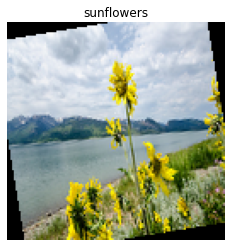

In [86]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

In [87]:
def tf_random_rotate_image(image, label):
  im_shape = image.shape
  [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
  image.set_shape(im_shape)
  return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


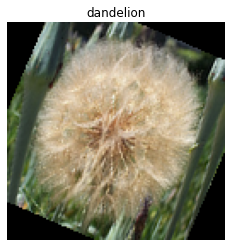

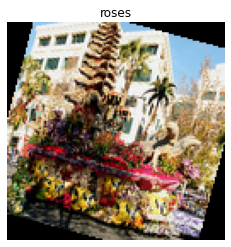

In [88]:
rot_ds = images_ds.map(tf_random_rotate_image)

for image, label in rot_ds.take(2):
  show(image, label)

### iii. Parsing tf.Example protocol buffer messages

In [89]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

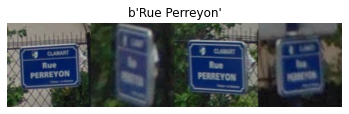

In [90]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

feature = parsed.features.feature
raw_img = feature['image/encoded'].bytes_list.value[0]
img = tf.image.decode_png(raw_img)
plt.imshow(img)
plt.axis('off')
_ = plt.title(feature["image/text"].bytes_list.value[0])

In [91]:
raw_example = next(iter(dataset))

In [92]:
def tf_parse(eg):
  example = tf.io.parse_example(
      eg[tf.newaxis], {
          'image/encoded': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
          'image/text': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
      })
  return example['image/encoded'][0], example['image/text'][0]

In [93]:
img, txt = tf_parse(raw_example)
print(txt.numpy())
print(repr(img.numpy()[:20]), "...")

b'Rue Perreyon'
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X' ...


In [94]:
decoded = dataset.map(tf_parse)
decoded

<MapDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [95]:
image_batch, text_batch = next(iter(decoded.batch(10)))
image_batch.shape

TensorShape([10])

### iv. Time series windowing

In [96]:
range_ds = tf.data.Dataset.range(100000)

In [97]:
batches = range_ds.batch(10, drop_remainder=True)

for batch in batches.take(5):
  print(batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]


In [98]:
def dense_1_step(batch):
  # Shift features and labels one step relative to each other.
  return batch[:-1], batch[1:]

predict_dense_1_step = batches.map(dense_1_step)

for features, label in predict_dense_1_step.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8]  =>  [1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18]  =>  [11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28]  =>  [21 22 23 24 25 26 27 28 29]


In [99]:
batches = range_ds.batch(15, drop_remainder=True)

def label_next_5_steps(batch):
  return (batch[:-5],   # Take the first 5 steps
          batch[-5:])   # take the remainder

predict_5_steps = batches.map(label_next_5_steps)

for features, label in predict_5_steps.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]  =>  [25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42 43 44]


In [100]:
feature_length = 10
label_length = 3

features = range_ds.batch(feature_length, drop_remainder=True)
labels = range_ds.batch(feature_length).skip(1).map(lambda labels: labels[:label_length])

predicted_steps = tf.data.Dataset.zip((features, labels))

for features, label in predicted_steps.take(5):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12]
[10 11 12 13 14 15 16 17 18 19]  =>  [20 21 22]
[20 21 22 23 24 25 26 27 28 29]  =>  [30 31 32]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42]
[40 41 42 43 44 45 46 47 48 49]  =>  [50 51 52]


In [101]:
window_size = 5

windows = range_ds.window(window_size, shift=1)
for sub_ds in windows.take(5):
  print(sub_ds)

<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>


In [102]:
for x in windows.flat_map(lambda x: x).take(30):
   print(x.numpy(), end=' ')

0 1 2 3 4 1 2 3 4 5 2 3 4 5 6 3 4 5 6 7 4 5 6 7 8 5 6 7 8 9 

In [103]:
def sub_to_batch(sub):
  return sub.batch(window_size, drop_remainder=True)

for example in windows.flat_map(sub_to_batch).take(5):
  print(example.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]


In [104]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def sub_to_batch(sub):
    return sub.batch(window_size, drop_remainder=True)

  windows = windows.flat_map(sub_to_batch)
  return windows

In [105]:
ds = make_window_dataset(range_ds, window_size=10, shift = 5, stride=3)

for example in ds.take(10):
  print(example.numpy())

[ 0  3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34 37]
[15 18 21 24 27 30 33 36 39 42]
[20 23 26 29 32 35 38 41 44 47]
[25 28 31 34 37 40 43 46 49 52]
[30 33 36 39 42 45 48 51 54 57]
[35 38 41 44 47 50 53 56 59 62]
[40 43 46 49 52 55 58 61 64 67]
[45 48 51 54 57 60 63 66 69 72]


In [106]:
dense_labels_ds = ds.map(dense_1_step)

for inputs,labels in dense_labels_ds.take(3):
  print(inputs.numpy(), "=>", labels.numpy())

[ 0  3  6  9 12 15 18 21 24] => [ 3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29] => [ 8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34] => [13 16 19 22 25 28 31 34 37]


### v. Resampling

In [107]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/data/creditcard.zip',
    fname='creditcard.zip',
    extract=True)

csv_path = zip_path.replace('.zip', '.csv')

69156864/69155632 [==============================] - 167s 2us/step


In [108]:
creditcard_ds = tf.data.experimental.make_csv_dataset(
    csv_path, batch_size=1024, label_name="Class",
    # Set the column types: 30 floats and an int.
    column_defaults=[float()]*30+[int()])

In [109]:
def count(counts, batch):
  features, labels = batch
  class_1 = labels == 1
  class_1 = tf.cast(class_1, tf.int32)

  class_0 = labels == 0
  class_0 = tf.cast(class_0, tf.int32)

  counts['class_0'] += tf.reduce_sum(class_0)
  counts['class_1'] += tf.reduce_sum(class_1)

  return counts

In [117]:
counts = creditcard_ds.take(10).reduce(
    initial_state={'class_0': 0, 'class_1': 0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)

[0.9955 0.0045]


In [118]:
negative_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==0)
    .repeat())
positive_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==1)
    .repeat())

In [119]:
for features, label in positive_ds.batch(10).take(1):
  print(label.numpy())

[1 1 1 1 1 1 1 1 1 1]


In [120]:
balanced_ds = tf.data.experimental.sample_from_datasets(
    [negative_ds, positive_ds], [0.5, 0.5]).batch(10)

In [121]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[1 1 1 1 1 0 1 0 0 0]
[1 0 1 0 1 0 1 1 0 0]
[1 0 1 0 0 0 1 1 1 1]
[0 0 0 0 0 1 0 0 1 1]
[0 1 1 1 1 1 0 0 0 0]
[0 0 0 1 1 0 1 1 1 1]
[1 0 0 0 0 1 1 0 1 0]
[1 1 0 1 0 0 1 0 1 0]
[1 0 0 0 0 0 0 0 1 0]
[1 1 1 0 1 0 0 1 1 1]


In [122]:
def class_func(features, label):
  return label

In [123]:
resampler = tf.data.experimental.rejection_resample(
    class_func, target_dist=[0.5, 0.5], initial_dist=fractions)

In [124]:
resample_ds = creditcard_ds.unbatch().apply(resampler).batch(10)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



In [125]:
balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

In [126]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[1 1 1 0 0 1 1 1 0 1]
[1 1 1 1 0 0 0 1 1 0]
[1 1 1 0 0 0 0 0 1 1]
[1 1 1 1 1 1 0 0 0 0]
[1 0 0 0 0 1 0 0 0 1]
[1 1 0 0 1 1 1 0 1 0]
[1 0 0 0 1 0 1 0 0 0]
[1 0 1 1 0 0 1 0 0 1]
[0 1 1 0 1 1 0 0 0 1]
[0 1 1 1 1 0 1 0 1 1]


## 6. Iterator Checkpointing

In [127]:
# To include your iterator in a checkpoint, pass the iterator to the tf.train.Checkpoint constructor.

range_ds = tf.data.Dataset.range(20)

iterator = iter(range_ds)
ckpt = tf.train.Checkpoint(step=tf.Variable(0), iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, '/tmp/my_ckpt', max_to_keep=3)

print([next(iterator).numpy() for _ in range(5)])

save_path = manager.save()

print([next(iterator).numpy() for _ in range(5)])

ckpt.restore(manager.latest_checkpoint)

print([next(iterator).numpy() for _ in range(5)])

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]
[5, 6, 7, 8, 9]


## 7. Using tf.data with tf.keras

In [128]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

In [129]:
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [130]:
model.fit(fmnist_train_ds, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7930 - accuracy: 0.7316
Epoch 2/2
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4700 - accuracy: 0.8390


In [131]:
model.fit(fmnist_train_ds.repeat(), epochs=2, steps_per_epoch=20)

Epoch 1/2
20/20 [==============================] - 0s 2ms/step - loss: 0.3654 - accuracy: 0.8687
Epoch 2/2
20/20 [==============================] - 0s 2ms/step - loss: 0.4692 - accuracy: 0.8328


In [132]:
loss, accuracy = model.evaluate(fmnist_train_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)

1875/1875 [==============================] - 3s 1ms/step - loss: 0.4394 - accuracy: 0.8511
Loss : 0.43935054540634155
Accuracy : 0.8511333465576172


In [133]:
loss, accuracy = model.evaluate(fmnist_train_ds.repeat(), steps=10)
print("Loss :", loss)
print("Accuracy :", accuracy)

10/10 [==============================] - 0s 2ms/step - loss: 0.4823 - accuracy: 0.8406
Loss : 0.4822565019130707
Accuracy : 0.840624988079071


In [134]:
predict_ds = tf.data.Dataset.from_tensor_slices(images).batch(32)
result = model.predict(predict_ds, steps = 10)
print(result.shape)

(320, 10)


In [135]:
result = model.predict(fmnist_train_ds, steps = 10)
print(result.shape)

(320, 10)


# reference

### https://tensorflow.google.cn/guide/data